In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from FinancialMachineLearning.feature_importance.importance import *
from FinancialMachineLearning.feature_importance.orthogonal import get_orthogonal_features
from FinancialMachineLearning.machine_learning.cross_validation import PurgedKFold, ml_cross_val_score
from FinancialMachineLearning.multiprocess.multiprocess import process_jobs

import yfinance as yf

start_date = '1980-01-01'
end_date = '2024-01-01'

apple = yf.download('AAPL', start = start_date, end = end_date)
apple_ret = np.log(apple.Close / apple.Close.shift(1)).dropna()
apple_ret.head()

[*********************100%%**********************]  1 of 1 completed


Date
1980-12-15   -0.053581
1980-12-16   -0.076231
1980-12-17    0.024450
1980-12-18    0.028580
1980-12-19    0.059239
Name: Close, dtype: float64

In [2]:
from FinancialMachineLearning.features.volatility import daily_volatility
vol = daily_volatility(apple.Close, lookback = 21)

In [3]:
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures
import statsmodels.api as sm

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 1, 11):
    try:
        df1 = np.log(apple[['Close']]).dropna()
        df2 = FractionalDifferentiatedFeatures.fracDiff(df1, d = d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index,'Close'], df2['Close'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['Close'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {d : .1f}, error: {e}')
        continue

d:  0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,0.343188,9.792414e-01,1.0,10850.0,-2.861806,1.000000
0.2,-1.813046,3.740040e-01,1.0,5.0,-3.929280,0.979474
0.3,-0.880119,7.944490e-01,1.0,12.0,-3.154972,0.918102
0.4,-1.677288,4.428508e-01,1.0,30.0,-2.964071,0.111914
0.5,-2.594777,9.408154e-02,1.0,77.0,-2.899878,0.693608
0.6,-5.989875,1.755992e-07,1.0,206.0,-2.875675,0.161244
0.7,-12.643280,1.419572e-23,1.0,588.0,-2.866468,0.282857
0.8,-24.600241,0.000000e+00,1.0,1790.0,-2.863156,0.025078
0.9,-47.132328,0.000000e+00,1.0,5255.0,-2.862090,-0.025633
1.0,-74.594776,0.000000e+00,1.0,10849.0,-2.861806,0.015737


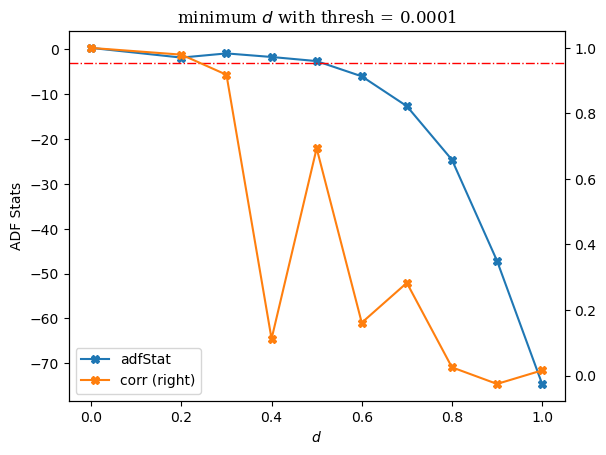

In [4]:
f,ax = plt.subplots()
out[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
ax.set_title(r'minimum $d$ with thresh = 0.0001', fontfamily = 'Serif', fontsize = 12)
ax.set_xlabel(r'$d$')
ax.set_ylabel('ADF Stats')
ax.grid(False)
display(out)

In [5]:
frac = FractionalDifferentiatedFeatures.fracDiff_FFD(apple[['Close']], 0.6)
apple['fracdiff'] = frac

In [6]:
from ta.volatility import BollingerBands
from ta.volume import money_flow_index, on_balance_volume
from ta.momentum import rsi
from ta.volume import volume_weighted_average_price
from ta.momentum import tsi

indicator_bb = BollingerBands(close = apple["Close"], window = 20, window_dev = 1)

apple['bb_bbm'] = indicator_bb.bollinger_mavg()
apple['bb_bbh'] = indicator_bb.bollinger_hband()
apple['bb_bbl'] = indicator_bb.bollinger_lband()

apple['mfi'] = money_flow_index(high = apple.High, 
                                low = apple.Low, 
                                close = apple.Close, 
                                volume = apple.Volume,
                                window = 20)
apple['obv'] = on_balance_volume(close = apple.Close, 
                                   volume = apple.Volume)
apple['rsi'] = rsi(close = apple.Close, window = 21)
apple['return'] = apple_ret
apple['vwap'] = volume_weighted_average_price(high = apple['High'],
                                              low = apple['Low'],
                                              close = apple['Close'],
                                              volume = apple['Volume'],
                                              window = 20)
apple['tsi'] = tsi(close = apple['Close'],
                   window_fast = 13,
                   window_slow = 15)

In [7]:
from FinancialMachineLearning.features.microstructure import *

corwin_schultz = CorwinSchultz(apple['High'], apple['Low'])
cs_estimator = corwin_schultz.corwin_schultz_estimator(window = 3)
cs_estimator.dropna().head()

Date
1980-12-17    0.0
1980-12-18    0.0
1980-12-19    0.0
1980-12-22    0.0
1980-12-23    0.0
Name: Spread, dtype: float64

In [8]:
apple['corwin_schultz'] = cs_estimator

In [9]:
apple.dropna(inplace = True)

primary model

In [10]:
apple['label'] = 0
apple.loc[(apple['Close'] > apple['bb_bbh']), 'label'] = 1
apple.loc[(apple['Close'] < apple['bb_bbl']), 'label'] = -1
apple.head()

,Open,High,Low,Close,Adj Close,Volume,fracdiff,bb_bbm,bb_bbh,bb_bbl,mfi,obv,rsi,return,vwap,tsi,corwin_schultz,label
Date,,,,,,,,,,,,,,,,,,
1983-04-13,0.189732,0.196987,0.189732,0.196429,0.152001,189772800,0.012824,0.188811,0.195516,0.182107,51.799118,9392633600,55.470753,0.034688,0.187497,-7.293462,0.033164,1
1983-04-14,0.196429,0.201451,0.194754,0.200893,0.155456,136371200,0.012453,0.189481,0.196672,0.182290,52.433171,9529004800,57.720672,0.022471,0.188048,-0.221682,0.002170,1
1983-04-15,0.200893,0.205915,0.200893,0.204241,0.158046,115001600,0.011924,0.190234,0.198110,0.182358,55.656188,9644006400,59.338579,0.016528,0.188747,6.419718,0.000000,1
1983-04-18,0.205357,0.213728,0.205357,0.209821,0.162364,155568000,0.014349,0.191127,0.200086,0.182168,57.093228,9799574400,61.890671,0.026954,0.189895,13.557115,0.000000,1
1983-04-19,0.209821,0.211496,0.206473,0.207589,0.160637,233878400,0.007735,0.191685,0.201282,0.182088,50.142743,9565696000,60.301072,-0.010695,0.191296,17.715774,0.012697,1


Meta Model

In [11]:
apple['meta_label'] = 0
apple.loc[(apple['label'] == 1) | (apple['label'] == -1), 'meta_label'] = 1
apple.head()

,Open,High,Low,Close,Adj Close,Volume,fracdiff,bb_bbm,bb_bbh,bb_bbl,mfi,obv,rsi,return,vwap,tsi,corwin_schultz,label,meta_label
Date,,,,,,,,,,,,,,,,,,,
1983-04-13,0.189732,0.196987,0.189732,0.196429,0.152001,189772800,0.012824,0.188811,0.195516,0.182107,51.799118,9392633600,55.470753,0.034688,0.187497,-7.293462,0.033164,1,1
1983-04-14,0.196429,0.201451,0.194754,0.200893,0.155456,136371200,0.012453,0.189481,0.196672,0.182290,52.433171,9529004800,57.720672,0.022471,0.188048,-0.221682,0.002170,1,1
1983-04-15,0.200893,0.205915,0.200893,0.204241,0.158046,115001600,0.011924,0.190234,0.198110,0.182358,55.656188,9644006400,59.338579,0.016528,0.188747,6.419718,0.000000,1,1
1983-04-18,0.205357,0.213728,0.205357,0.209821,0.162364,155568000,0.014349,0.191127,0.200086,0.182168,57.093228,9799574400,61.890671,0.026954,0.189895,13.557115,0.000000,1,1
1983-04-19,0.209821,0.211496,0.206473,0.207589,0.160637,233878400,0.007735,0.191685,0.201282,0.182088,50.142743,9565696000,60.301072,-0.010695,0.191296,17.715774,0.012697,1,1


In [12]:
matrix = apple[['fracdiff','mfi','obv','rsi','return','vwap','tsi','corwin_schultz','meta_label']]
matrix.head()

,fracdiff,mfi,obv,rsi,return,vwap,tsi,corwin_schultz,meta_label
Date,,,,,,,,,
1983-04-13,0.012824,51.799118,9392633600,55.470753,0.034688,0.187497,-7.293462,0.033164,1
1983-04-14,0.012453,52.433171,9529004800,57.720672,0.022471,0.188048,-0.221682,0.002170,1
1983-04-15,0.011924,55.656188,9644006400,59.338579,0.016528,0.188747,6.419718,0.000000,1
1983-04-18,0.014349,57.093228,9799574400,61.890671,0.026954,0.189895,13.557115,0.000000,1
1983-04-19,0.007735,50.142743,9565696000,60.301072,-0.010695,0.191296,17.715774,0.012697,1


In [13]:
from sklearn.model_selection import train_test_split

X = matrix.drop('meta_label', axis = 1)
y = matrix['meta_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [14]:
cont = pd.Series(X_train.index, index = X_train.index, name = 't1')

In [15]:
forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 3,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = X_train, y = y_train)
oob_score = fit.oob_score_
cv_gen = PurgedKFold(n_splits = 5, samples_info_sets = cont)
oos_score = ml_cross_val_score(forest, X_train, y_train, cv_gen = cv_gen, scoring = accuracy_score).mean()
mdi = mean_decrease_impurity(fit, X_train.columns)

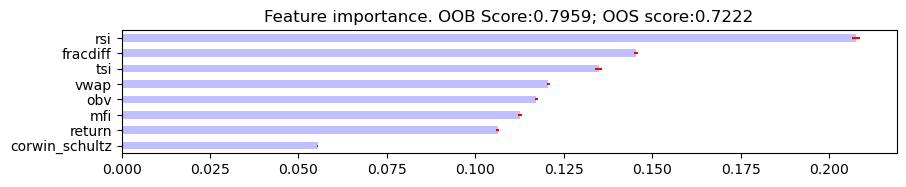

In [16]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './MDI_feature_importance_Apple.png'
)
plt.grid(False)
plt.show()

In [17]:
mda = mean_decrease_accuracy(fit, X_train, y_train, cv_gen, scoring = accuracy_score)

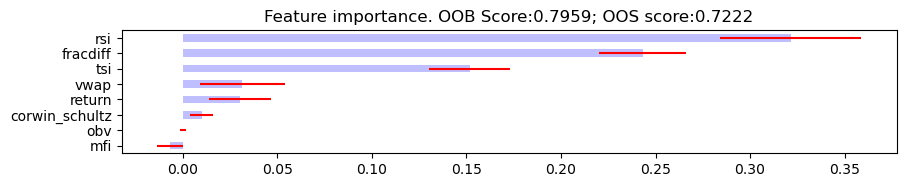

In [18]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './MDA_feature_importance_Apple.png'
)
plt.grid(False)
plt.show()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


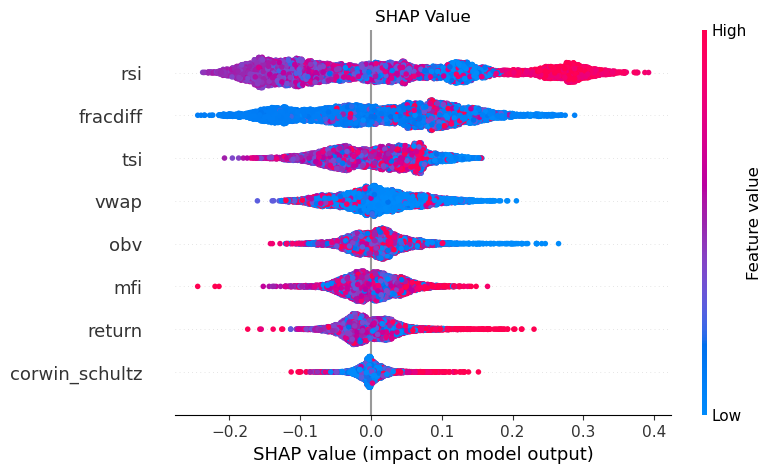

In [19]:
import shap
import tqdm

forest_explain = shap.TreeExplainer(fit)
shap_values_train = forest_explain(X_train)
plt.grid(False)
plt.title('SHAP Value')
shap.plots.beeswarm(
    shap_values_train[:,:,1], 
    max_display = len(shap_values_train.feature_names),
    plot_size = (8, 5)
)
plt.show()